# Rolling Planning mit Tardiness (Max)

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check
from src.utils.production_process import initialize as init
from src.utils.production_process import filter as process_filter
from src.utils.production_process import gen_deadline as gen_deadline

# Solver Model
from src.models.lp import tardiness_scheduling as lp_tard_schedule
from src.models.lp import tardiness_rescheduling as lp_tard_reschedule
import src.models.heuristics.fcfs as fcfs

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
pd.set_option('display.max_rows', 16)

In [2]:
max_time = 60*10 # 10 min

## Generierung des Datensatzes für 12 Tage (Ankunft)

In [3]:
day_count = 12

In [4]:
basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 1, shift_length = 1440,
                                                        u_b_mmax = 0.94, shuffle = True,
                                                        job_seed=40, arrival_seed=80
                                                       )
df_jobs_times = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_jobs_times


Schedule-Informationen:
  Makespan: 2319


,Job,Routing_ID,Arrival,Ready Time,Deadline
0,0,9,49,1440,1109.0
1,1,5,130,1440,1104.0
2,2,3,151,1440,1437.0
3,3,4,226,1440,998.0
4,4,6,386,1440,1203.0
...,...,...,...,...,...
15,15,5,1142,1440,2116.0
16,16,6,1254,1440,2071.0
17,17,7,1285,1440,2343.0
18,18,8,1397,1440,2569.0


## Params

In [5]:
# fix
day_length = 1440

In [6]:
# init
day_numb = 0

day_start = 0
day_end = 0

# Initialisierung (Tag 1)

In [21]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [24]:
# I)
df_jssp_curr, df_times_curr = process_filter.jobs_by_ready_time(df_jobs_times, df_jssp, ready_time = day_start)
df_times_curr

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,0,9,49,1440,1109.0
1,1,5,130,1440,1104.0
2,2,3,151,1440,1437.0
3,3,4,226,1440,998.0
4,4,6,386,1440,1203.0
...,...,...,...,...,...
15,15,5,1142,1440,2116.0
16,16,6,1254,1440,2071.0
17,17,7,1285,1440,2343.0
18,18,8,1397,1440,2569.0


### Scheduling

In [11]:
# Scheduling
df_schedule = lp_tard_schedule.solve_jssp_sum(df_jssp_curr, df_times_curr, 
                                              solver= "HiGHS", msg=False, 
                                              timeLimit=max_time, gapRel= 0.002)
df_schedule

BigM: 6000

Solver-Informationen:
  Summe Tardiness         : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2140
  Anzahl Constraints      : 4020
  Laufzeit                : ~74 Sekunden


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,1,0,130,1104.0,M02,130.0,84.0,214.0,0
1,1,1,130,1104.0,M01,214.0,2.0,216.0,0
2,1,2,130,1104.0,M05,216.0,52.0,268.0,0
3,3,0,226,998.0,M02,226.0,14.0,240.0,0
4,3,1,226,998.0,M00,240.0,6.0,246.0,0
...,...,...,...,...,...,...,...,...,...
195,19,9,1398,2458.0,M07,2335.0,45.0,2380.0,0
196,18,6,1397,2569.0,M06,2340.0,40.0,2380.0,0
197,18,7,1397,2569.0,M07,2380.0,89.0,2469.0,0
198,18,8,1397,2569.0,M04,2469.0,26.0,2495.0,0


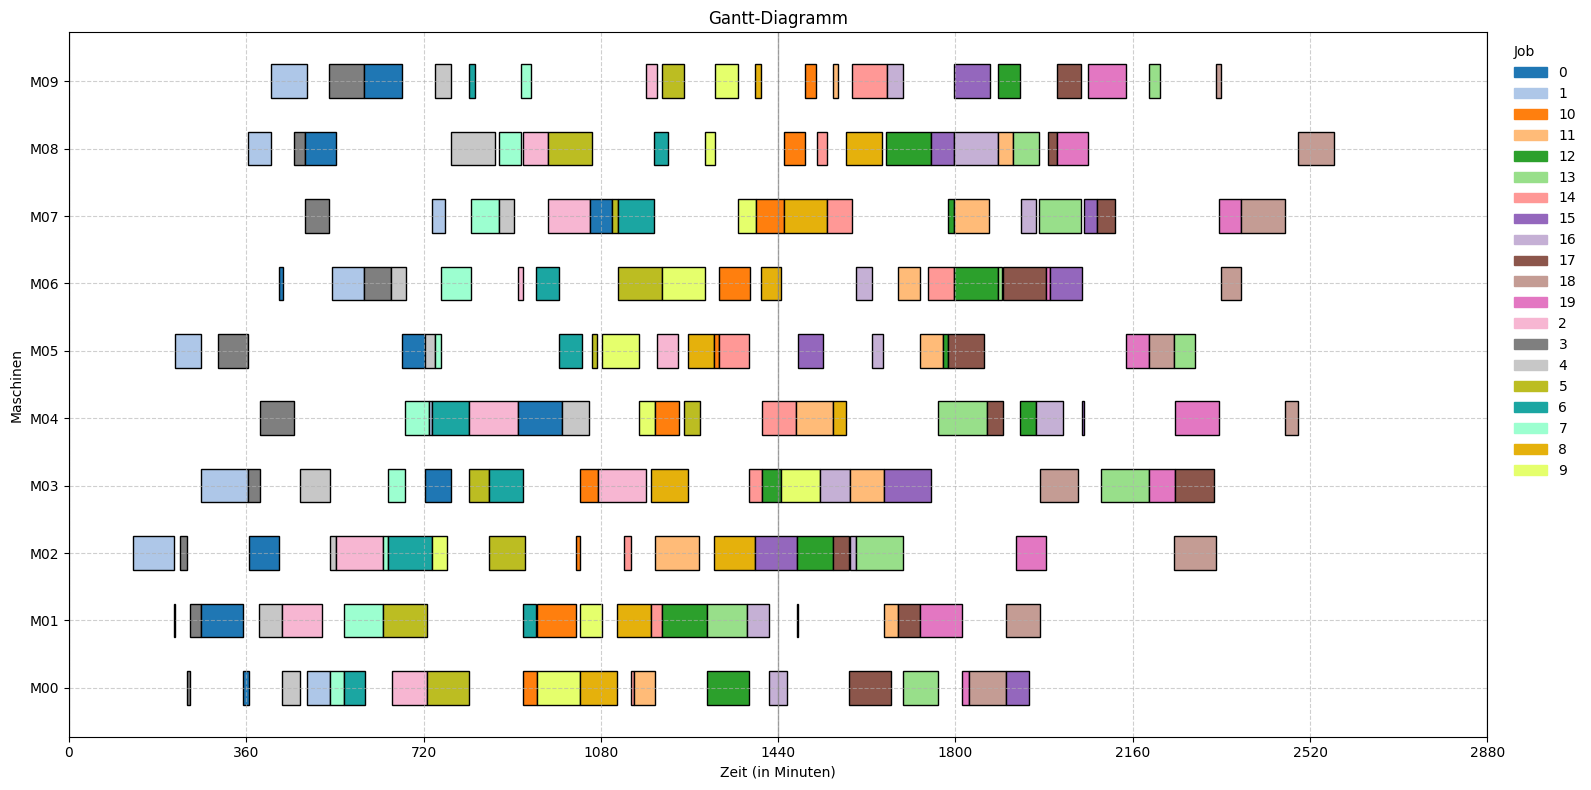

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [12]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

In [13]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            20
0 - 60        0
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


### Simulation

In [14]:
simulation = ProductionSimulation(df_schedule, sigma=0.2)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 0 02:10:00] Job 1 started on M02
[Day 0 03:38:55] Job 1 finished on M02 (after 88 minutes 55 seconds)
[Day 0 03:38:55] Job 1 started on M01
[Day 0 03:41:01] Job 1 finished on M01 (after 02 minutes 06 seconds)
[Day 0 03:41:01] Job 1 started on M05
[Day 0 03:46:00] Job 3 started on M02
[Day 0 03:57:47] Job 3 finished on M02 (after 11 minutes 47 seconds)
[Day 0 04:00:00] Job 3 started on M00
[Day 0 04:04:46] Job 3 finished on M00 (after 04 minutes 47 seconds)
[Day 0 04:06:00] Job 3 started on M01
[Day 0 04:28:18] Job 3 finished on M01 (after 22 minutes 18 seconds)
[Day 0 04:28:18] Job 0 started on M01
[Day 0 04:46:48] Job 1 finished on M05 (after 65 minutes 47 seconds)
[Day 0 04:46:48] Job 1 started on M03
[Day 0 05:02:00] Job 3 started on M05
[Day 0 05:44:56] Job 0 finished on M01 (after 76 minutes 38 seconds)
[Day 0 05:53:00] Job 0 started on M00
[Day 0 06:05:09] Job 3 finished on M05 (after 63 minutes 10 seconds)
[Day 0 06:08:51] Job 0 finished on M00 (after 15 minutes 51 seconds)

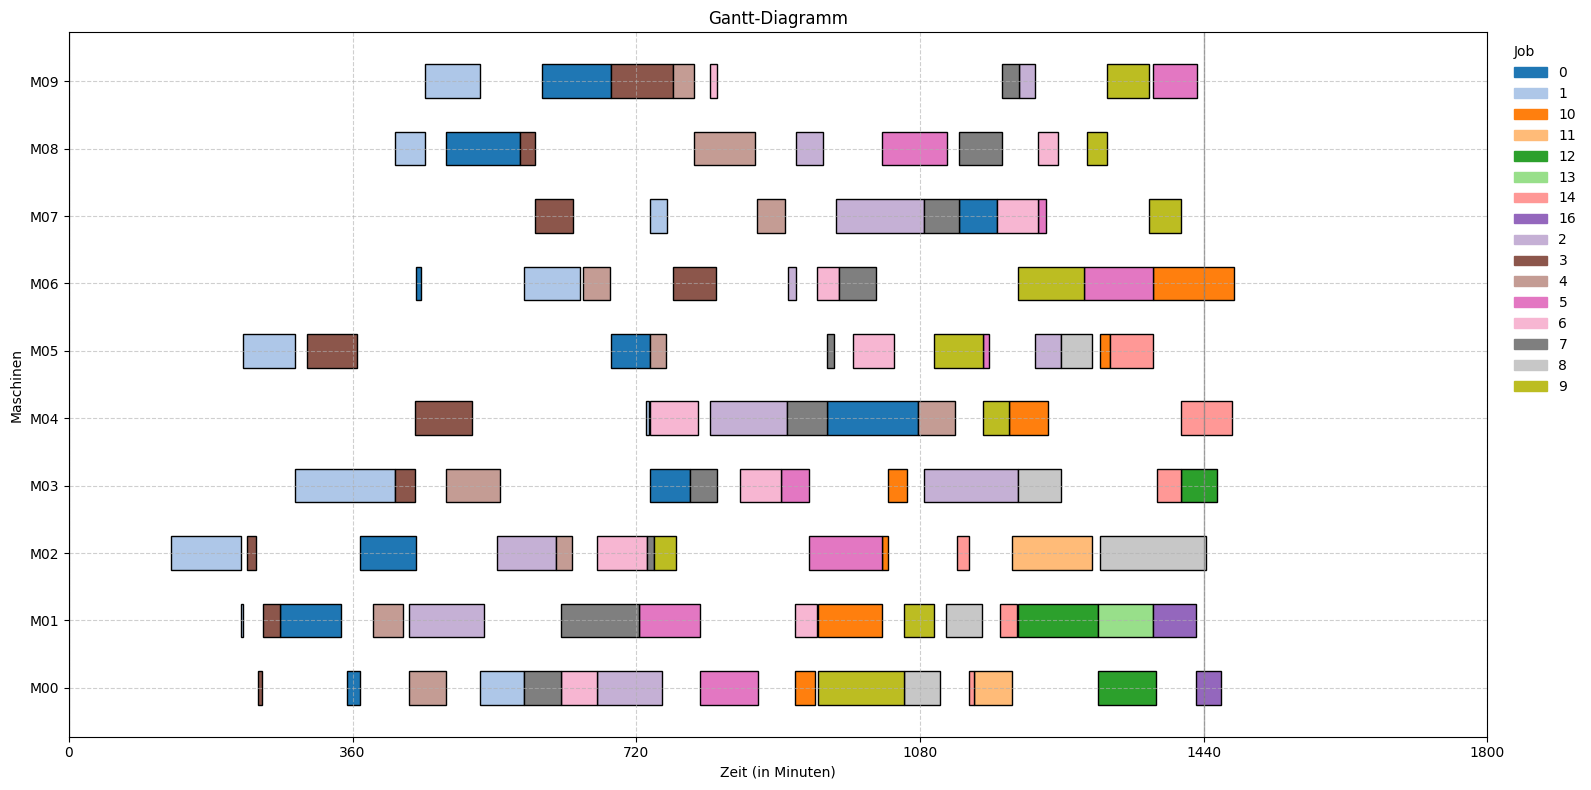

In [15]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine")
else:
    print(f"Nothing executed on day {day_numb}")

In [16]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,5,9,464,1579.0,M04,1249.0,33.0,1282.0,0
1,15,0,1142,2116.0,M02,1394.0,84.0,1478.0,0
2,8,5,526,1698.0,M09,1394.0,11.0,1405.0,0
3,10,7,922,1697.0,M07,1395.0,56.0,1451.0,0
4,8,6,526,1698.0,M06,1405.0,40.0,1445.0,0
...,...,...,...,...,...,...,...,...,...
81,19,9,1398,2458.0,M07,2335.0,45.0,2380.0,0
82,18,6,1397,2569.0,M06,2340.0,40.0,2380.0,0
83,18,7,1397,2569.0,M07,2380.0,89.0,2469.0,0
84,18,8,1397,2569.0,M04,2469.0,26.0,2495.0,0


#### Export

In [17]:
data_path = get_path("data", "tardiness")

In [18]:
df_jssp.to_csv(data_path / "02LP_all_jssp.csv", index = False)
df_jobs_times.to_csv(data_path / "02LP_all_times.csv", index = False)

In [19]:
df_schedule.to_csv(data_path / "02LP_init_schedule.csv", index = False)
df_execution.to_csv(data_path / "02LP_execution.csv", index = False)
df_plan_undone.to_csv(data_path / "02LP_init_undone.csv", index = False)